## EXPLORATORY DATA ANALYSIS Project 

#### Marjan Rezvani
- Rezvani.mrb@gmail.com

### Goal: 
- What are the busiest stations?
- What are the best time to prompt app users to get a citibike membership?
- Which citibike stations are unable to meet demand from MTA riders and should be expanded?

#### To do:
- High exit rate for top 10 busiest MTA stations in the morning 
- High entry rate for top 10 busiest MTA stations in the afternoon or evening  
- Finding the top 10 busiest citibike stations
- Identifying the busiest hours of citibike stations. 
- Finding the nearest citibike stations and see if it's frequently low on bikes or all the bikes are gone during that time of day.
    

In this project, I am going to use the data of several months from MTA website http://web.mta.info/developers/turnstile.html, which is including several features such as station, date, time, entries that I will explain each of them and explore them in continue.
In addition I will work on "citibike.csv" dataset for the month of September 2021 to reach my goal.


#### MTA Data: 
- C/A : Control Area name/Booth name. This is the internal identification of a booth at a given station.
- UNIT : Remote unit ID of station.
- SCP : Subunit/Channel/position represents a specific address for a given device. 
- STATION : Name assigned to the subway station by operations planning. This name is used in all references to stations, as well as in debit/credit purchase receipts, and customer’s bank activity statements.
- LINENAME : Train lines stopping at this location. Can contain up to 20 single character identifier. When more than one train line appears, it is usually intercepting train lines, in major stations where the passenger can transfer between any one of the lines.
- DIVISION : Represents the Line originally the station belonged to BMT, IRT, or IND. Each section of the system is assigned a unique line name, usually paired with its original operating company or division (Brooklyn–Manhattan Transit Corporation (BMT), Interborough Rapid Transit Company (IRT), and Independent Subway System (IND).
- DATE : Represents the date of the audit data.
- TIME : Represents the date of the audit data.
- DESC : Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
- ENTRIES : The cumulative entry register value for a device
- EXITS : The cumulative exit register value for a device

#### Citibike Data:
- ride_id
- rideable_type
- started_at	
- ended_at
- start_station_name
- end_station_name
- start_lat
- start_lng	
- end_lat
- end_lng
- member_casual



## The Methods and Tools

##### Data ingestion and storage:
- Pandas
- SQLite
#### Data cleaning and manipulation:
- Python Libraries: Pandas, Numpy
#### Presentation tools:
- Matplotlib
- Seaborn

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

%matplotlib inline

#### First of all, I am going through citibike dataset.

In [195]:
citibike = pd.read_csv('202108-citibike-tripdata.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [196]:
citibike.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,FB6B89D05B67EBED,classic_bike,2021-08-24 15:59:57,2021-08-24 16:42:07,Broadway & E 21 St,6098.10,Central Park North & Adam Clayton Powell Blvd,7617.07,40.739888,-73.989586,40.799484,-73.955613,member
1,E13DA3E30CEF8DFC,classic_bike,2021-08-18 13:12:01,2021-08-18 13:21:26,E 13 St & 2 Ave,5820.08,Henry St & Grand St,5294.04,40.731539,-73.985302,40.714211,-73.981095,member
2,56617490AB8AE69C,classic_bike,2021-08-17 14:31:23,2021-08-17 14:35:34,E 95 St & 3 Ave,7365.13,E 84 St & Park Ave,7243.04,40.784903,-73.950503,40.778627,-73.957721,member
3,CA908B271C7D6663,classic_bike,2021-08-11 10:00:12,2021-08-11 10:31:01,Madison Ave & E 82 St,7188.13,E 84 St & Park Ave,7243.04,40.778131,-73.960694,40.778627,-73.957721,casual
4,3E170CE1F4FE179D,classic_bike,2021-08-12 19:28:38,2021-08-12 19:48:50,E 74 St & 1 Ave,6953.08,E 84 St & Park Ave,7243.04,40.768974,-73.954823,40.778627,-73.957721,casual


In [197]:
citibike.shape

(3072478, 13)

- I have a code which is used to count the total number of trip activities involved each station. For example, if a rider starts a trip at station A and ends at station B, each station A and B will receive +1 count for the trip. 

In [232]:
import csv
from functools import reduce
def extract(x):
    return x['start_station_name'],x['end_station_name']
def reducer(count, y):
    for station_name in y:
        count[station_name] = count.get(station_name, 0)+1 
    return count
with open('202108-citibike-tripdata.csv','r')as fi:
    reader = csv.DictReader(fi)
    output1 = reduce(reducer , map(extract, reader), {})
list(output1.items())[:10]    

[('Broadway & E 21 St', 20555),
 ('Central Park North & Adam Clayton Powell Blvd', 11597),
 ('E 13 St & 2 Ave', 17684),
 ('Henry St & Grand St', 10030),
 ('E 95 St & 3 Ave', 3076),
 ('E 84 St & Park Ave', 5186),
 ('Madison Ave & E 82 St', 5724),
 ('E 74 St & 1 Ave', 9226),
 ('Newtown Ave & 23 St', 2501),
 ('35 St & 21 Ave', 454)]

- Plotting the number of trips taken by hour of the day in '''citibike.csv'''. In this task, we would write a generator to convert each line of an input citibike CSV into a stream of “hour of the day” values.

In [374]:
def citibike2hod(filename):
    with open(filename, 'r') as fi:
        reader = csv.DictReader(fi)
        for row in reader:
            starttime = dateutil.parser.parse(row['starttime'])
            yield(starttime.hour)

In [375]:
import dateutil
count = {}
for hod in citibike2hod('202108-citibike-tripdata.csv'):
    count[hod] = count.get(hod,0)+1

Text(0.5, 1.0, 'Number of trips taken by hour of the day for September')

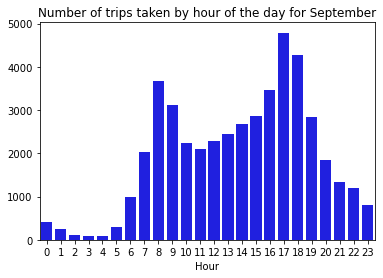

In [376]:
ax = sns.barplot(x=list(count.keys()),
                 y=list(count.values()),
                 color='b')

plt.xlabel('Hour')

plt.title('Number of trips taken by hour of the day for September')

- as it's obvious in the graph, 7-9 am and 4-7 PM are peak riding hours during the week.

In [340]:
def citibike2hod(filename):
    with open(filename, 'r') as fi:
        reader = csv.DictReader(fi)
        for row in reader:
            starttime = dateutil.parser.parse(row['starttime'])
            yield(starttime.day)

In [341]:
import dateutil
count = {}
for hod in citibike2hod('202108-citibike-tripdata.csv'):
    count[hod] = count.get(hod,0)+1

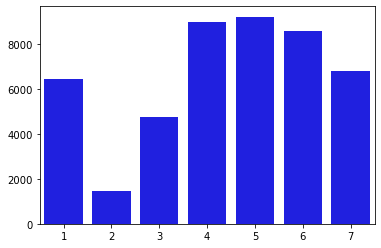

In [342]:
ax = sns.barplot(x=list(count.keys()),
                 y=list(count.values()),
                 color='b')

### Getting other Data of MTA and exploring it

- I tried to work on a more complete dataset of MTA,and went through stations and latitude and longitude variables and plan to use these variables in the future to combine with citibike data.

In [3]:
df_new = pd.read_csv('NYC_Transit_Subway_Entrance_And_Exit_Data.csv')

In [5]:
df_new.head(2)

,Division,Line,Station Name,Station Latitude,Station Longitude,Route1,Route2,Route3,Route4,Route5,...,ADA,ADA Notes,Free Crossover,North South Street,East West Street,Corner,Entrance Latitude,Entrance Longitude,Station Location,Entrance Location
0,BMT,4 Avenue,25th St,40.660397,-73.998091,R,NaN,NaN,NaN,NaN,...,False,NaN,False,4th Ave,25th St,SE,40.660323,-73.997952,"(40.660397, -73.998091)","(40.660323, -73.997952)"
1,BMT,4 Avenue,25th St,40.660397,-73.998091,R,NaN,NaN,NaN,NaN,...,False,NaN,False,4th Ave,25th St,SW,40.660489,-73.998220,"(40.660397, -73.998091)","(40.660489, -73.99822)"


In [6]:
df_new.columns

Index(['Division', 'Line', 'Station Name', 'Station Latitude',
       'Station Longitude', 'Route1', 'Route2', 'Route3', 'Route4', 'Route5',
       'Route6', 'Route7', 'Route8', 'Route9', 'Route10', 'Route11',
       'Entrance Type', 'Entry', 'Exit Only', 'Vending', 'Staffing',
       'Staff Hours', 'ADA', 'ADA Notes', 'Free Crossover',
       'North South Street', 'East West Street', 'Corner', 'Entrance Latitude',
       'Entrance Longitude', 'Station Location', 'Entrance Location'],
      dtype='object')

In [7]:
df_new['Station Name'].value_counts()

34th St                               41
23rd St                               40
14th St                               26
59th St                               25
86th St                               22
                                      ..
Botanic Gardens                        1
Broadway Junction-East New York        1
Broad Channel                          1
Bedford Park Blvd-Lehman College       1
Westchester Square-East Tremont Av     1
Name: Station Name, Length: 356, dtype: int64

In [18]:
d = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

In [19]:
d.head()

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes
0,1,1,R01,BMT,Astoria,Astoria-Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan,0,NaN
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan,1,NaN
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan,0,NaN
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan,0,NaN
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan,0,NaN


In [20]:
d.columns

Index(['Station ID', 'Complex ID', 'GTFS Stop ID', 'Division', 'Line',
       'Stop Name', 'Borough', 'Daytime Routes', 'Structure', 'GTFS Latitude',
       'GTFS Longitude', 'North Direction Label', 'South Direction Label',
       'ADA', 'ADA Notes'],
      dtype='object')

# EDA for MTA

- Then for the beginning of my work, I would like to work on last 4 month of 2021, September, October, November and December, and explore the data.
I get the data from the MTA link, and then will concatenate the data together for all weeks of these months. 

In [25]:
Sep_w1 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_210904.txt"
Sep_w2 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_210911.txt"
Sep_w3 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_210918.txt"
Sep_w4 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_210925.txt"

In [26]:
Sep_week1 = pd.read_csv(Sep_w1)
Sep_week2 = pd.read_csv(Sep_w2)
Sep_week3 = pd.read_csv(Sep_w3)
Sep_week4 = pd.read_csv(Sep_w4)

In [27]:
frames_1 = [Sep_week1, Sep_week2, Sep_week3, Sep_week4]

df_sep = pd.concat(frames_1)

In [28]:
df_sep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 839516 entries, 0 to 210399
Data columns (total 11 columns):
 #   Column                                                                Non-Null Count   Dtype 
---  ------                                                                --------------   ----- 
 0   C/A                                                                   839516 non-null  object
 1   UNIT                                                                  839516 non-null  object
 2   SCP                                                                   839516 non-null  object
 3   STATION                                                               839516 non-null  object
 4   LINENAME                                                              839516 non-null  object
 5   DIVISION                                                              839516 non-null  object
 6   DATE                                                                  839516 non-null  objec

In [29]:
df_sep.shape

(839516, 11)

In [30]:
Oct_w1 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_211002.txt"
Oct_w2 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_211009.txt"
Oct_w3 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_211016.txt"
Oct_w4 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_211023.txt"
#Oct_w4 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_211030.txt"


In [31]:
Oct_week1 = pd.read_csv(Oct_w1)
Oct_week2 = pd.read_csv(Oct_w2)
Oct_week3 = pd.read_csv(Oct_w3)
Oct_week4 = pd.read_csv(Oct_w4)

In [32]:
frames_2 = [Oct_week1, Oct_week2, Oct_week3, Oct_week4]

df_oct = pd.concat(frames_2)

In [33]:
df_oct.shape

(839959, 11)

In [35]:
Nov_w1 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_211106.txt"
Nov_w2 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_211113.txt"
Nov_w3 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_211120.txt"
Nov_w4 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_211127.txt"

In [36]:
Nov_week1 = pd.read_csv(Nov_w1)
Nov_week2 = pd.read_csv(Nov_w2)
Nov_week3 = pd.read_csv(Nov_w3)
Nov_week4 = pd.read_csv(Nov_w4)

In [37]:
frames_3 = [Nov_week1, Nov_week2, Nov_week3, Nov_week4]

df_nov = pd.concat(frames_3)

In [38]:
df_nov.shape

(841562, 11)

In [39]:
df_nov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841562 entries, 0 to 210188
Data columns (total 11 columns):
 #   Column                                                                Non-Null Count   Dtype 
---  ------                                                                --------------   ----- 
 0   C/A                                                                   841562 non-null  object
 1   UNIT                                                                  841562 non-null  object
 2   SCP                                                                   841562 non-null  object
 3   STATION                                                               841562 non-null  object
 4   LINENAME                                                              841562 non-null  object
 5   DIVISION                                                              841562 non-null  object
 6   DATE                                                                  841562 non-null  objec

In [40]:
Dec_w1 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_211204.txt"
Dec_w2 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_211211.txt"
Dec_w3 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_211218.txt"
Dec_w4 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_211225.txt"

In [41]:
Dec_week1 = pd.read_csv(Dec_w1)
Dec_week2 = pd.read_csv(Dec_w2)
Dec_week3 = pd.read_csv(Dec_w3)
Dec_week4 = pd.read_csv(Dec_w4)

In [42]:
frames_4 = [Dec_week1, Dec_week2, Dec_week3, Dec_week4]

df_dec = pd.concat(frames_4)

In [43]:
df_dec.shape

(841198, 11)

In [44]:
df_dec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841198 entries, 0 to 210382
Data columns (total 11 columns):
 #   Column                                                                Non-Null Count   Dtype 
---  ------                                                                --------------   ----- 
 0   C/A                                                                   841198 non-null  object
 1   UNIT                                                                  841198 non-null  object
 2   SCP                                                                   841198 non-null  object
 3   STATION                                                               841198 non-null  object
 4   LINENAME                                                              841198 non-null  object
 5   DIVISION                                                              841198 non-null  object
 6   DATE                                                                  841198 non-null  objec

In [45]:
full_data = [df_sep, df_oct, df_nov, df_dec]

data = pd.concat(full_data)

### Data Exploration and Cleaning

In [46]:
data.shape

(3362235, 11)

So there are 3362235 records or instances and 11 columns. let's check the columns.

In [47]:
data.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

as you can see, we need to remove the space for 'EXITS' feature.

In [67]:
data.columns = [column.strip() for column in data.columns]

In [68]:
print(data.columns)

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'DATETIME', 'DAY', 'TURNSTILE'],
      dtype='object')


In [50]:
#Checking duplicates rows and drop.

data.drop_duplicates(subset=None, keep="first", inplace=True)

In [51]:
#Checking null values based on columns

data.isnull().sum()

C/A                                                                     0
UNIT                                                                    0
SCP                                                                     0
STATION                                                                 0
LINENAME                                                                0
DIVISION                                                                0
DATE                                                                    0
TIME                                                                    0
DESC                                                                    0
ENTRIES                                                                 0
EXITS                                                                   0
dtype: int64

In [52]:
data.shape

(3362235, 11)

In [53]:
data.sample(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
105161,N521,R300,01-00-01,2 AV,F,IND,10/21/2021,00:00:00,REGULAR,4960458,5106758
143814,R160,R164,02-00-02,66 ST-LINCOLN,1,IRT,09/29/2021,01:00:00,REGULAR,5871934,896725
145037,R164,R167,00-00-00,86 ST,1,IRT,11/04/2021,13:00:00,REGULAR,1114183,1867155


- the ‘ENTRIES’ and ‘EXIT’ columns are cumulative serial numbers that increase with time. Also, the rows of the ‘TIME’ column progress at approximately 4 hour blocks and each turnstile has a unique combinations of ‘UNIT’ and ‘SCP’ number as shown. Some rows are also found to be duplicates, and are removed.

In [54]:
data.DATE.value_counts().sort_index()

08/28/2021    30021
08/29/2021    29754
08/30/2021    30738
08/31/2021    29865
09/01/2021    30159
              ...  
12/20/2021    30120
12/21/2021    30015
12/22/2021    30005
12/23/2021    30232
12/24/2021    29969
Name: DATE, Length: 112, dtype: int64

In [57]:
data.groupby(['UNIT','SCP'])['STATION'].nunique().sort_values()  
#checking combination of 'UNIT' and 'SCP' is unique to each station,implying each combination refers to a unique turnstile"

UNIT  SCP     
R001  00-00-00    1
R270  00-00-01    1
      00-00-00    1
R269  01-06-01    1
      01-06-00    1
                 ..
R112  01-06-01    1
      01-06-00    1
      01-05-01    1
R113  00-00-04    1
R572  01-03-04    1
Name: STATION, Length: 5046, dtype: int64

In [58]:
# Creating DATETIME as datetime64 column that concatenate "DATE" and "TIME"

data['DATETIME'] = data["DATE"]+ " " + data["TIME"]

data['DATETIME'] = pd.to_datetime(data['DATETIME'], format='%m/%d/%Y %H:%M:%S')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3362235 entries, 0 to 210382
Data columns (total 12 columns):
 #   Column                                                                Dtype         
---  ------                                                                -----         
 0   C/A                                                                   object        
 1   UNIT                                                                  object        
 2   SCP                                                                   object        
 3   STATION                                                               object        
 4   LINENAME                                                              object        
 5   DIVISION                                                              object        
 6   DATE                                                                  object        
 7   TIME                                                                  obj

In [59]:
data.describe()

,ENTRIES,EXITS
count,3.362235e+06,3.362235e+06
mean,4.184798e+07,3.372513e+07
std,2.198453e+08,1.940607e+08
min,0.000000e+00,0.000000e+00
25%,2.306530e+05,1.124580e+05
50%,1.377808e+06,8.545780e+05
75%,5.995788e+06,3.986998e+06
max,2.147386e+09,2.133797e+09


In [60]:
#Create a column that called "DAY"
data["DAY"]= data["DATETIME"].dt.day_name()

#Checking sample 5 rows
data.sample(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,DAY
36029,H019,R294,00-00-01,MORGAN AV,L,BMT,11/12/2021,07:00:00,REGULAR,343989,173513,2021-11-12 07:00:00,Friday
193015,R532,R328,00-00-01,METS-WILLETS PT,7,IRT,11/01/2021,17:00:00,REGULAR,101392,81962,2021-11-01 17:00:00,Monday
196788,R550,R072,00-03-04,34 ST-HUDSON YD,7,IRT,10/18/2021,08:00:00,REGULAR,2394207,904891,2021-10-18 08:00:00,Monday
46370,N012,R035,01-05-01,168 ST,AC1,IND,08/30/2021,20:00:00,REGULAR,262144,20,2021-08-30 20:00:00,Monday
68932,N121B,R438,00-00-02,RALPH AV,C,IND,12/06/2021,00:00:00,REGULAR,1623,1706,2021-12-06 00:00:00,Monday


In [61]:
# Adding "TURNSTILE" columns that concatenate 'C/A', 'UNIT', 'SCP'

data["TURNSTILE"] = data["C/A"]+"-"+data["UNIT"]+"-"+data["SCP"]

data.head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,DAY,TURNSTILE
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2021,00:00:00,REGULAR,7625998,2609113,2021-08-28 00:00:00,Saturday,A002-R051-02-00-00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2021,04:00:00,REGULAR,7626014,2609117,2021-08-28 04:00:00,Saturday,A002-R051-02-00-00


In [66]:
data.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               ',
       'DATETIME', 'DAY', 'TURNSTILE'],
      dtype='object')

In [69]:
# Working with some columns

my_data = data[["TURNSTILE","STATION","DATE","TIME","DATETIME","DAY","ENTRIES", "EXITS"]]
my_data.head()


,TURNSTILE,STATION,DATE,TIME,DATETIME,DAY,ENTRIES,EXITS
0,A002-R051-02-00-00,59 ST,08/28/2021,00:00:00,2021-08-28 00:00:00,Saturday,7625998,2609113
1,A002-R051-02-00-00,59 ST,08/28/2021,04:00:00,2021-08-28 04:00:00,Saturday,7626014,2609117
2,A002-R051-02-00-00,59 ST,08/28/2021,08:00:00,2021-08-28 08:00:00,Saturday,7626024,2609135
3,A002-R051-02-00-00,59 ST,08/28/2021,12:00:00,2021-08-28 12:00:00,Saturday,7626086,2609191
4,A002-R051-02-00-00,59 ST,08/28/2021,16:00:00,2021-08-28 16:00:00,Saturday,7626206,2609221


In [70]:
my_data.STATION.value_counts().sort_values(ascending=False).head(10)

34 ST-PENN STA     68819
FULTON ST          64447
GRD CNTRL-42 ST    63519
23 ST              49068
86 ST              43708
CANAL ST           39063
59 ST              37551
CHAMBERS ST        37423
34 ST-HERALD SQ    35977
ATL AV-BARCLAY     34411
Name: STATION, dtype: int64

In [71]:
turnstiles_daily = (my_data.groupby(["TURNSTILE", "STATION", "DATE",'DAY'],as_index=False).ENTRIES.first())
                                                

In [72]:
turnstiles_daily.head()

,TURNSTILE,STATION,DATE,DAY,ENTRIES
0,A002-R051-02-00-00,59 ST,08/28/2021,Saturday,7625998
1,A002-R051-02-00-00,59 ST,08/29/2021,Sunday,7626446
2,A002-R051-02-00-00,59 ST,08/30/2021,Monday,7626814
3,A002-R051-02-00-00,59 ST,08/31/2021,Tuesday,7627394
4,A002-R051-02-00-00,59 ST,09/01/2021,Wednesday,7628030


In [73]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["TURNSTILE", "STATION"])["DATE","ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [74]:
turnstiles_daily.head()

,TURNSTILE,STATION,DATE,DAY,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002-R051-02-00-00,59 ST,08/28/2021,Saturday,7625998,NaN,NaN
1,A002-R051-02-00-00,59 ST,08/29/2021,Sunday,7626446,08/28/2021,7625998.0
2,A002-R051-02-00-00,59 ST,08/30/2021,Monday,7626814,08/29/2021,7626446.0
3,A002-R051-02-00-00,59 ST,08/31/2021,Tuesday,7627394,08/30/2021,7626814.0
4,A002-R051-02-00-00,59 ST,09/01/2021,Wednesday,7628030,08/31/2021,7627394.0


In [75]:
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [76]:
(turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]
    .groupby(["TURNSTILE", "STATION"])
    .size())

TURNSTILE           STATION        
A011-R080-01-03-00  57 ST-7 AV         111
A013-R081-01-03-00  49 ST                1
A015-R081-00-00-02  49 ST                1
A046-R463-00-05-02  CANAL ST             1
A049-R088-02-05-00  CORTLANDT ST        67
                                      ... 
R604-R108-03-00-03  BOROUGH HALL         1
R612-R057-01-05-00  ATL AV-BARCLAY       1
R622-R123-00-00-00  FRANKLIN AV        111
R730-R431-00-00-04  EASTCHSTER/DYRE     99
S101-R070-00-00-02  ST. GEORGE           7
Length: 242, dtype: int64

In [77]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
_ = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

120 5264647.0
8 5597788.0
16 1951349.0
157 1458386.0
24 453053819.0
1562968059 113672.0
98 9631533.0
370 5609637.0
98 9768823.0
35 3295183.0
33565264 188178.0
327710 1560335855.0
117453575 459314.0
66 3272783.0
125 2547896.0
67136062 290420.0
1979658535 9048037.0
587209577 2350364.0
687930078 2705017.0
863597 1979303.0
369104707 1458931.0
1966525 196562.0
83942366 378998.0
7 6114337.0
262 7403575.0
4824 9321305.0
100704896 418210.0
123 12553627.0
534 557914826.0
46006400 7827911.0
258 67470015.0
2150004 1043924984.0
219 1132812.0
393358 3680673.0
2031766 4435696.0
1636499479 2450105.0
642372 2358853.0
992215084 1896551.0
1198 2958702.0
55 11194758.0
102 8302412.0
131 1617704.0
241 2818347.0
11123659 4624026.0
5 11123659.0
1891101745 1104755.0
297 3154049.0
3 10685516.0
574 3502001.0
393217 135403959.0
50331648 262144.0
19 2570917.0
4278411 25672.0
90 1040931947.0
229 21943808.0
94 3530461.0
201331991 798740.0
25 5768873.0
34 3231628.0
1089962103 146746222.0
146744193 1089940447.0
35390

In [78]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

120 5264647.0
8 5597788.0
16 1951349.0
157 1458386.0
24 453053819.0
1562968059 113672.0
98 9631533.0
370 5609637.0
98 9768823.0
35 3295183.0
33565264 188178.0
327710 1560335855.0
117453575 459314.0
66 3272783.0
125 2547896.0
67136062 290420.0
1979658535 9048037.0
587209577 2350364.0
687930078 2705017.0
863597 1979303.0
369104707 1458931.0
1966525 196562.0
83942366 378998.0
7 6114337.0
262 7403575.0
4824 9321305.0
100704896 418210.0
123 12553627.0
534 557914826.0
46006400 7827911.0
258 67470015.0
2150004 1043924984.0
219 1132812.0
393358 3680673.0
2031766 4435696.0
1636499479 2450105.0
642372 2358853.0
992215084 1896551.0
1198 2958702.0
55 11194758.0
102 8302412.0
131 1617704.0
241 2818347.0
11123659 4624026.0
5 11123659.0
1891101745 1104755.0
297 3154049.0
3 10685516.0
574 3502001.0
393217 135403959.0
50331648 262144.0
19 2570917.0
4278411 25672.0
90 1040931947.0
229 21943808.0
94 3530461.0
201331991 798740.0
25 5768873.0
34 3231628.0
1089962103 146746222.0
146744193 1089940447.0
35390

In [79]:
turnstiles_daily.head()

,TURNSTILE,STATION,DATE,DAY,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002-R051-02-00-00,59 ST,08/29/2021,Sunday,7626446,08/28/2021,7625998.0,448.0
2,A002-R051-02-00-00,59 ST,08/30/2021,Monday,7626814,08/29/2021,7626446.0,368.0
3,A002-R051-02-00-00,59 ST,08/31/2021,Tuesday,7627394,08/30/2021,7626814.0,580.0
4,A002-R051-02-00-00,59 ST,09/01/2021,Wednesday,7628030,08/31/2021,7627394.0,636.0
5,A002-R051-02-00-00,59 ST,09/02/2021,Thursday,7628533,09/01/2021,7628030.0,503.0


In [80]:
station_daily = turnstiles_daily.groupby(["TURNSTILE","STATION", "DATE","DAY"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily.sort_values('DAILY_ENTRIES', ascending=False).head(10)

,TURNSTILE,STATION,DATE,DAY,DAILY_ENTRIES
316910,PTH04-R551-00-01-01,GROVE STREET,11/17/2021,Wednesday,992031.0
464247,R307-R207-01-00-00,135 ST,10/30/2021,Saturday,983841.0
154295,N078-R175-01-00-00,14 ST,12/03/2021,Friday,972913.0
167801,N095A-R014-01-03-03,FULTON ST,11/02/2021,Tuesday,863597.0
464358,R307-R207-01-00-01,135 ST,10/30/2021,Saturday,857148.0
322323,PTH07-R550-00-00-07,CITY / BUS,10/19/2021,Tuesday,831247.0
473411,R327-R361-01-06-00,PELHAM PKWY,09/07/2021,Tuesday,798740.0
510025,R528-R097-00-00-02,JUNCTION BLVD,09/18/2021,Saturday,794786.0
510023,R528-R097-00-00-02,JUNCTION BLVD,09/16/2021,Thursday,788680.0
509914,R528-R097-00-00-01,JUNCTION BLVD,09/18/2021,Saturday,774463.0


In [145]:
m1 = station_daily[(station_daily["TURNSTILE"]=="PTH04-R551-00-01-01")&(station_daily["STATION"]=='GROVE STREET')&(station_daily["DATE"]>="09/01/2021")&(station_daily["DATE"]<="10/01/2021")]


Text(0.5, 1.0, 'Daily Entries for TURNSTILE PTH04/R551/00-01-01 at GROVE STREET Station in September')

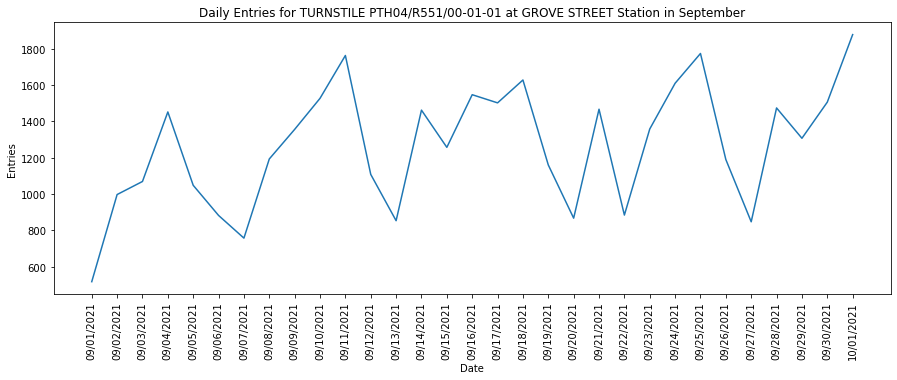

In [85]:

plt.figure(figsize=(15,5))
plt.plot(m1['DATE'], m1['DAILY_ENTRIES'])
plt.ylabel('Entries')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.title('Daily Entries for TURNSTILE PTH04/R551/00-01-01 at GROVE STREET Station in September')



In [89]:
station_daily_entries = turnstiles_daily.groupby(["STATION", "DATE","DAY"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily_entries.head(7)

,STATION,DATE,DAY,DAILY_ENTRIES
0,1 AV,08/29/2021,Sunday,6852.0
1,1 AV,08/30/2021,Monday,5903.0
2,1 AV,08/31/2021,Tuesday,7146.0
3,1 AV,09/01/2021,Wednesday,7887.0
4,1 AV,09/02/2021,Thursday,7311.0
5,1 AV,09/03/2021,Friday,6037.0
6,1 AV,09/04/2021,Saturday,8318.0


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


([<matplotlib.axis.XTick at 0x16f3b7fd0>,
 [Text(0, 0, 'Mo'),
  Text(1, 0, 'Tu'),
  Text(2, 0, 'We'),
  Text(3, 0, 'Th'),
  Text(4, 0, 'Fr'),
  Text(5, 0, 'St'),
  Text(6, 0, 'Sn')])

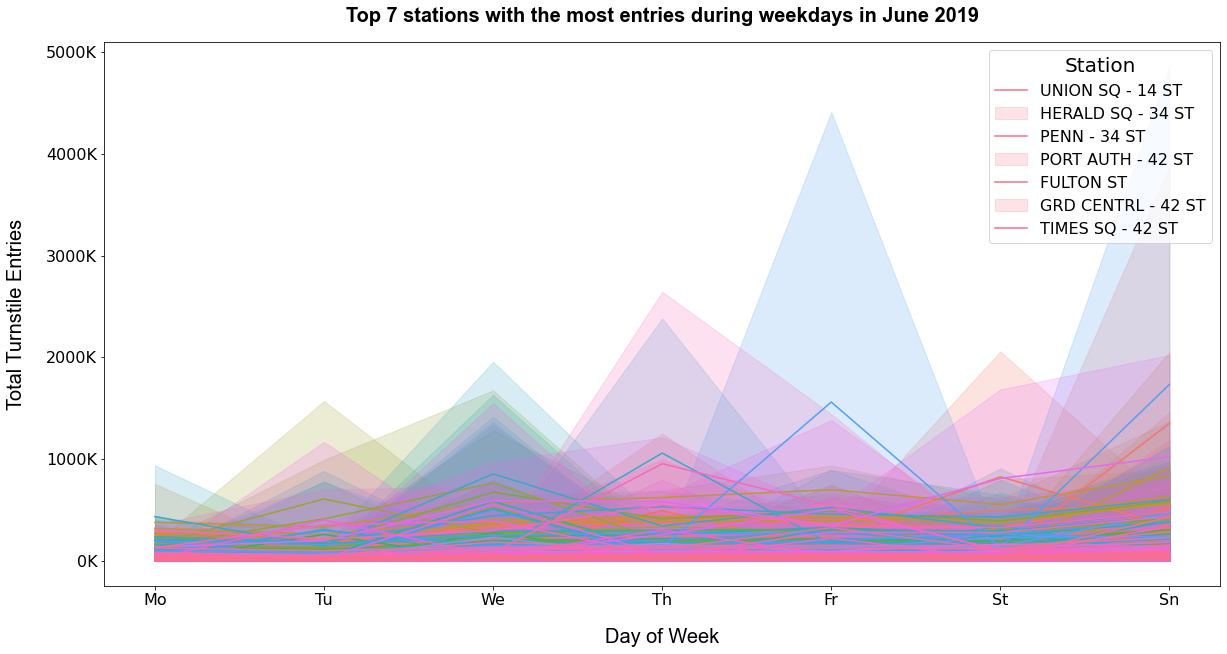

In [90]:
fig, axs = plt.subplots(figsize=[20, 10])

chart_weekday_entries = sns.lineplot(x = "DAY",
                                     y = "DAILY_ENTRIES",
                                     hue = "STATION",
                                     data = station_daily_entries)

chart_weekday_entries.set_title("Top 7 stations with the most entries during weekdays in June 2019",
                             fontname="Arial",
                             fontsize=20,
                             fontweight='bold',
                             pad=20)

ylabels = [str(int(y)) + "K" for y in chart_weekday_entries.get_yticks()/100]
chart_weekday_entries.set_yticklabels(ylabels)

chart_weekday_entries.set_ylabel("Total Turnstile Entries", 
                                 fontname='Arial', 
                                 fontsize=20, 
                                 labelpad=20)

chart_weekday_entries.set_xlabel("Day of Week", 
                                 fontname='Arial', 
                                 fontsize=20,
                                 labelpad=20)

chart_weekday_entries.tick_params(labelsize=16)


legend = ['UNION SQ - 14 ST','HERALD SQ - 34 ST','PENN - 34 ST','PORT AUTH - 42 ST','FULTON ST','GRD CENTRL - 42 ST','TIMES SQ - 42 ST']
chart_weekday_entries.legend(legend, title = "Station", fontsize=16, title_fontsize=20)
plt.xticks(np.arange(7),['Mo','Tu','We','Th','Fr','St','Sn'])


In [147]:
df_entries = turnstiles_daily[(turnstiles_daily.DAILY_ENTRIES > 0) & (turnstiles_daily.DAILY_ENTRIES < 200000)]

df_entries.head()

,TURNSTILE,STATION,DATE,DAY,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002-R051-02-00-00,59 ST,08/29/2021,Sunday,7626446,08/28/2021,7625998.0,448.0
2,A002-R051-02-00-00,59 ST,08/30/2021,Monday,7626814,08/29/2021,7626446.0,368.0
3,A002-R051-02-00-00,59 ST,08/31/2021,Tuesday,7627394,08/30/2021,7626814.0,580.0
4,A002-R051-02-00-00,59 ST,09/01/2021,Wednesday,7628030,08/31/2021,7627394.0,636.0
5,A002-R051-02-00-00,59 ST,09/02/2021,Thursday,7628533,09/01/2021,7628030.0,503.0


In [452]:
mta_1 = df_entries[(df_entries["TURNSTILE"]=="A002-R051-02-00-00")&(df_entries["DATE"]>="09/01/2021")&(df_entries["DATE"]<="10/01/2021")]

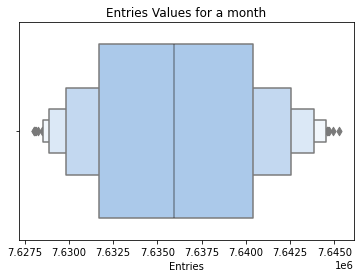

In [326]:
#boxenplot for september

ax = sns.boxenplot(x='ENTRIES', data=mta_1,palette="pastel").set(xlabel='Entries',title="Entries Values for a month")

In [149]:
station_daily = df_entries.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,08/29/2021,6852.0
1,1 AV,08/30/2021,5903.0
2,1 AV,08/31/2021,7146.0
3,1 AV,09/01/2021,7887.0
4,1 AV,09/02/2021,7311.0


In [162]:
top_stations = station_daily.groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index()

top_stations.head(10)

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,6327458.0
1,34 ST-HERALD SQ,4625988.0
2,GRD CNTRL-42 ST,4578564.0
3,86 ST,4251720.0
4,23 ST,4159542.0
5,42 ST-PORT AUTH,4071304.0
6,14 ST-UNION SQ,3993667.0
7,125 ST,3917716.0
8,PATH NEW WTC,3755503.0
9,TIMES SQ-42 ST,3630290.0


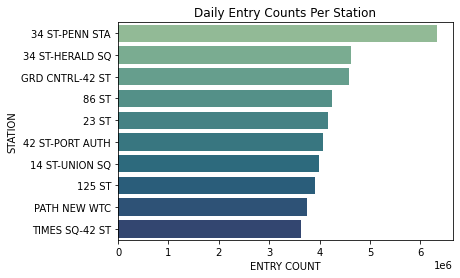

In [163]:
# Barplot
sns.barplot(x="DAILY_ENTRIES", y="STATION", data=top_stations.head(10),palette='crest')
plt.title('Daily Entry Counts Per Station')
plt.xlabel('ENTRY COUNT')
plt.ylabel('STATION')
plt.xticks(rotation='horizontal')
plt.show()

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


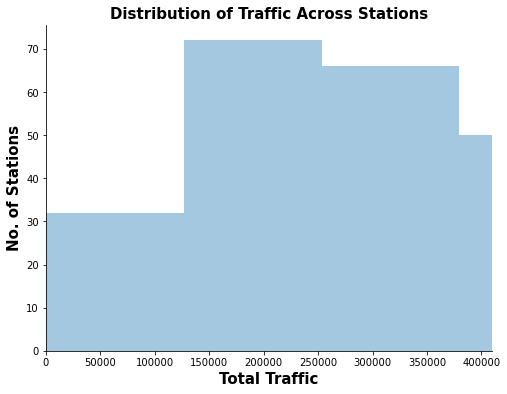

In [171]:
group_station11 = df_entries.groupby('STATION')['DAILY_ENTRIES'].sum().sort_values(ascending=False)

fig1 = plt.figure(figsize=[8,6])
ax1 = sns.distplot(group_station11,bins=50,kde=False)
plt.xlim([0,410000])
plt.ylabel('No. of Stations',fontsize=15, weight='bold')
plt.xlabel('Total Traffic', fontsize=15, weight='bold')
plt.title('Distribution of Traffic Across Stations',fontsize=15,weight='bold')
sns.despine()

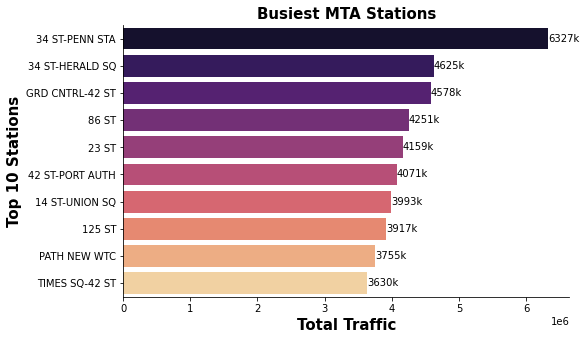

In [174]:
plt.figure(figsize=[8,5])
ax = sns.barplot(data=group_station11.head(10).reset_index(),x='DAILY_ENTRIES',y='STATION',palette='magma')
plt.xlabel('Total Traffic',weight='bold',fontsize=15)
plt.ylabel('Top 10 Stations',weight='bold',fontsize=15)


plt.title('Busiest MTA Stations', weight='bold',fontsize='15')
for p in ax.patches:
        ax.annotate(str(int(p.get_width()/1000))+'k', (p.get_width(), p.get_y()+0.5))
sns.despine()

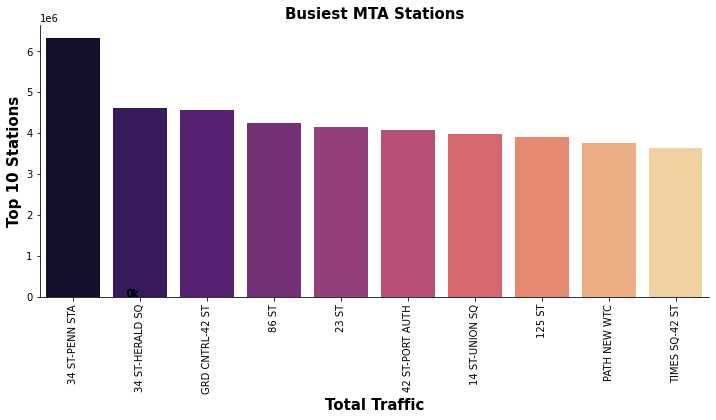

In [182]:
plt.figure(figsize=[12,5])
ax = sns.barplot(data=top_stations.head(10),x='STATION',y='DAILY_ENTRIES',palette='magma')
plt.xlabel('Total Traffic',weight='bold',fontsize=15)
plt.ylabel('Top 10 Stations',weight='bold',fontsize=15)
#plt.xticks(range(0,400001,50000),[str(int(i/1000))+'k' for i in range(0,400001,50000)])
plt.title('Busiest MTA Stations', weight='bold',fontsize='15')
plt.xticks(rotation=90)
for p in ax.patches:
        ax.annotate(str(int(p.get_width()/1000))+'k', (p.get_width(), p.get_y()+0.5))
sns.despine()

In [445]:
turnstiles_daily_evening = (my_data.groupby(["TURNSTILE", "STATION", "DATE",'TIME'],as_index=False).ENTRIES.first())



In [447]:
turnstiles_daily_evening[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily_evening
                                                       .groupby(["TURNSTILE", "STATION"])["DATE","ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [448]:
turnstiles_daily_evening.head(3)

,TURNSTILE,STATION,DATE,TIME,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002-R051-02-00-00,59 ST,08/28/2021,00:00:00,7625998,NaN,NaN
1,A002-R051-02-00-00,59 ST,08/28/2021,04:00:00,7626014,08/28/2021,7625998.0
2,A002-R051-02-00-00,59 ST,08/28/2021,08:00:00,7626024,08/28/2021,7626014.0


In [449]:
turnstiles_daily_evening.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [450]:

def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily_evening["DAILY_ENTRIES"] = turnstiles_daily_evening.apply(get_daily_counts, axis=1, max_counter=1000000)

50 5264647.0
6 5597948.0
16 1951349.0
19 1458405.0
1996226560 649791.0
649802 1996226560.0
19 453053850.0
1562968059 113672.0
27 9631915.0
151 5610355.0
35 9769328.0
35 3295646.0
33565227 188201.0
327709 1560335855.0
117453575 459314.0
66 3272795.0
85 2548273.0
15848006 2216515.0
2216520 15848006.0
10487784 2024.0
2024 10487784.0
67135623 290615.0
1979658988 9048204.0
587209328 2350595.0
687929780 2705590.0
863597 1979303.0
369104536 1459204.0
1966428 196562.0
83942360 379281.0
7 6114636.0
6 7403757.0
4824 9321838.0
100704896 418210.0
2 12553652.0
5 23234554.0
23234665 5.0
45 557914846.0
46006400 7828674.0
4 67470015.0
2150004 1043925813.0
13 1132851.0
393221 3680678.0
2031657 4435939.0
1636499479 2450105.0
642372 2359165.0
992215084 1896551.0
444 2959133.0
55 11194856.0
38 8302412.0
11 1617728.0
9 2818429.0
11123659 4624026.0
5 11123659.0
1891101745 1104755.0
43 3154069.0
3 10685559.0
574 3502646.0
393217 135403962.0
50331648 262144.0
19 2570919.0
4278354 25672.0
67 1040931990.0
229 2

In [452]:
station_daily_evening = turnstiles_daily_evening.groupby(["TURNSTILE","STATION", "DATE","TIME"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily_evening.sort_values('DAILY_ENTRIES', ascending=False).head(10)

,TURNSTILE,STATION,DATE,TIME,DAILY_ENTRIES
1918895,PTH04-R551-00-01-01,GROVE STREET,11/16/2021,10:30:47,992742.0
2802629,R307-R207-01-00-00,135 ST,10/30/2021,00:00:00,984596.0
936763,N078-R175-01-00-00,14 ST,12/03/2021,08:00:00,973154.0
1018460,N095A-R014-01-03-03,FULTON ST,11/02/2021,01:00:00,863597.0
2803300,R307-R207-01-00-01,135 ST,10/30/2021,00:00:00,857611.0
1987732,PTH13-R541-00-04-08,THIRTY ST,12/12/2021,00:07:37,848922.0
1987731,PTH13-R541-00-04-08,THIRTY ST,12/11/2021,21:06:11,848922.0
1949852,PTH07-R550-00-00-07,CITY / BUS,10/18/2021,08:05:47,831618.0
1987527,PTH13-R541-00-04-08,THIRTY ST,11/06/2021,13:28:11,820799.0
1987528,PTH13-R541-00-04-08,THIRTY ST,11/06/2021,16:15:37,820799.0


In [457]:
entry_evening = station_daily_evening[(station_daily_evening["DATE"]>="09/01/2021")&(station_daily_evening["DATE"]<"10/01/2021")&(station_daily_evening["TIME"]>="16:00:00")&(station_daily_evening["TIME"]<="19:00:00")]


In [460]:
station_daily_entry = entry_evening.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
evening_entry = station_daily_entry.sort_values('DAILY_ENTRIES', ascending=False).head(10)

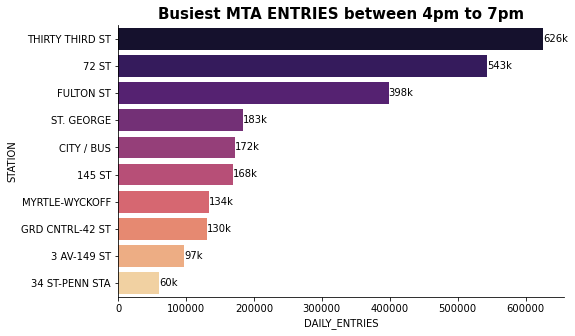

In [462]:
plt.figure(figsize=[8,5])
ax = sns.barplot(data=evening_entry.reset_index(),x='DAILY_ENTRIES',y='STATION',palette='magma')

plt.title('Busiest MTA ENTRIES between 4pm to 7pm', weight='bold',fontsize='15')
for p in ax.patches:
        ax.annotate(str(int(p.get_width()/1000))+'k', (p.get_width(), p.get_y()+0.5))
sns.despine()

### Daily EXIT Explores: 

- In order to find number of people that exit each day, I first sort the columns in the data frame, then I take the difference between consecutive rows for ‘EXITS’ and ‘NEXT_DAY_EXITS’ respectively to make new column 'EXIT_COUNT'. The new columns (named as ‘EXIT_COUNT’) will then represent the actual number of EXITS through each day.

In [294]:
df_exits = my_data.groupby(['STATION','TURNSTILE','DATE','TIME','DATETIME','DAY'], as_index=False)['EXITS'].min()
df_exits['NEXT_DAY_EXITS'] = df_exits['EXITS']
df_exits.NEXT_DAY_EXITS = df_exits.NEXT_DAY_EXITS.shift(-1)
df_exits['EXIT_COUNT'] = df_exits['NEXT_DAY_EXITS'] - df_exits['EXITS']

In [295]:
df_exits.head()

,STATION,TURNSTILE,DATE,TIME,DATETIME,DAY,EXITS,NEXT_DAY_EXITS,EXIT_COUNT
0,1 AV,H007-R248-00-00-00,08/28/2021,00:00:00,2021-08-28 00:00:00,Saturday,18021900,18022048.0,148.0
1,1 AV,H007-R248-00-00-00,08/28/2021,04:00:00,2021-08-28 04:00:00,Saturday,18022048,18022234.0,186.0
2,1 AV,H007-R248-00-00-00,08/28/2021,08:00:00,2021-08-28 08:00:00,Saturday,18022234,18022538.0,304.0
3,1 AV,H007-R248-00-00-00,08/28/2021,12:00:00,2021-08-28 12:00:00,Saturday,18022538,18023101.0,563.0
4,1 AV,H007-R248-00-00-00,08/28/2021,16:00:00,2021-08-28 16:00:00,Saturday,18023101,18023715.0,614.0


In [296]:
df_exits = df_exits[(df_exits.EXIT_COUNT > 0) & (df_exits.EXIT_COUNT < 200000)]

df_exits.head()

,STATION,TURNSTILE,DATE,TIME,DATETIME,DAY,EXITS,NEXT_DAY_EXITS,EXIT_COUNT
0,1 AV,H007-R248-00-00-00,08/28/2021,00:00:00,2021-08-28 00:00:00,Saturday,18021900,18022048.0,148.0
1,1 AV,H007-R248-00-00-00,08/28/2021,04:00:00,2021-08-28 04:00:00,Saturday,18022048,18022234.0,186.0
2,1 AV,H007-R248-00-00-00,08/28/2021,08:00:00,2021-08-28 08:00:00,Saturday,18022234,18022538.0,304.0
3,1 AV,H007-R248-00-00-00,08/28/2021,12:00:00,2021-08-28 12:00:00,Saturday,18022538,18023101.0,563.0
4,1 AV,H007-R248-00-00-00,08/28/2021,16:00:00,2021-08-28 16:00:00,Saturday,18023101,18023715.0,614.0


In [297]:
df_exits.shape

(2857776, 9)

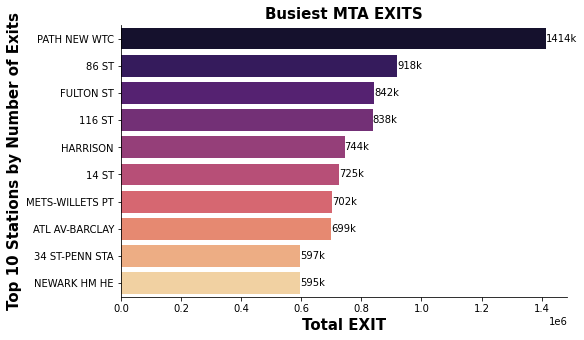

In [301]:
plt.figure(figsize=[8,5])
ax = sns.barplot(data=top_exit_station.reset_index(),x='EXIT_COUNT',y='STATION',palette='magma')
plt.xlabel('Total EXIT',weight='bold',fontsize=15)
plt.ylabel('Top 10 Stations by Number of Exits',weight='bold',fontsize=15)

plt.title('Busiest MTA EXITS', weight='bold',fontsize='15')
for p in ax.patches:
        ax.annotate(str(int(p.get_width()/1000))+'k', (p.get_width(), p.get_y()+0.5))
sns.despine()

In [437]:
top_exit_morning = df_exits[(df_exits["DATE"]>="09/01/2021")&(df_exits["DATE"]<"10/01/2021")&(df_exits["TIME"]>="07:00:00")&(df_exits["TIME"]<="10:00:00")]


In [ ]:
station_daily_exit_ = top_exit_morning.groupby(["STATION", "DATE"])[['EXIT_COUNT']].sum().reset_index()
morning_exit = station_daily_exit_.sort_values('EXIT_COUNT', ascending=False).head(20)

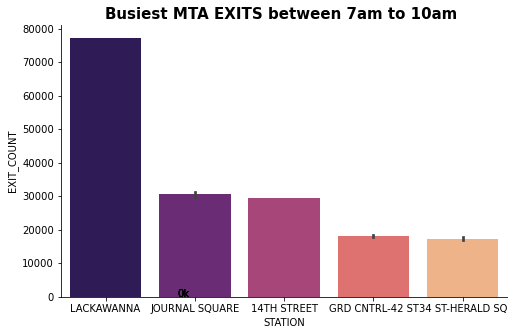

In [434]:
plt.figure(figsize=[8,5])
ax = sns.barplot(data=morning_exit,y='EXIT_COUNT',x='STATION',palette='magma')

plt.title('Busiest MTA EXITS between 7am to 10am ', weight='bold',fontsize='15')
for p in ax.patches:
        ax.annotate(str(int(p.get_width()/1000))+'k', (p.get_width(), p.get_y()+0.5))
sns.despine()

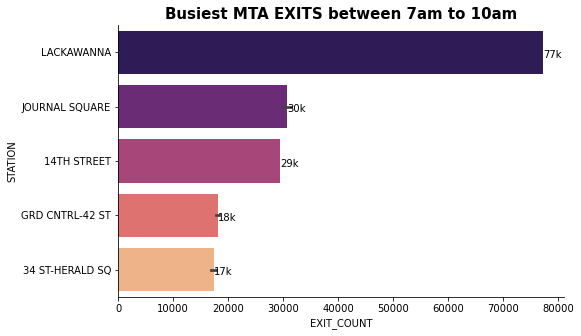

In [442]:
plt.figure(figsize=[8,5])
ax = sns.barplot(data=morning_exit.reset_index(),x='EXIT_COUNT',y='STATION',palette='magma')

plt.title('Busiest MTA EXITS between 7am to 10am', weight='bold',fontsize='15')
for p in ax.patches:
        ax.annotate(str(int(p.get_width()/1000))+'k', (p.get_width(), p.get_y()+0.5))
sns.despine()

In [302]:
df1 = df_exits.groupby('DATE')['EXIT_COUNT'].sum().reset_index()

In [303]:
df1['datetime'] = pd.to_datetime(df1['DATE'], infer_datetime_format=True)

In [304]:
df1['weekday'] = df1['datetime'].dt.dayofweek

In [305]:
df1.groupby('weekday')['EXIT_COUNT'].mean().reset_index().sort_values('weekday')


,weekday,EXIT_COUNT
0,0,2.662784e+06
1,1,2.880872e+06
2,2,2.903160e+06
3,3,2.736392e+06
4,4,6.000471e+06
5,5,2.058938e+06
6,6,1.638582e+06


In [306]:
df1.head()

,DATE,EXIT_COUNT,datetime,weekday
0,08/28/2021,1660301.0,2021-08-28,5
1,08/29/2021,1526462.0,2021-08-29,6
2,08/30/2021,2252531.0,2021-08-30,0
3,08/31/2021,2418800.0,2021-08-31,1
4,09/01/2021,2291115.0,2021-09-01,2


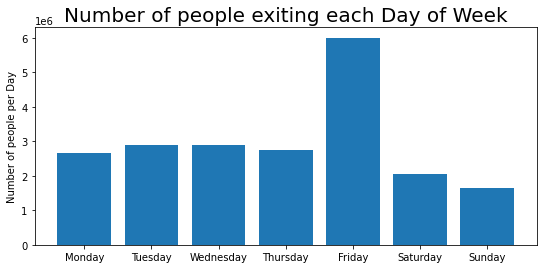

In [307]:
Days =['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=[9,4])
plt.ylabel('Number of people per Day', fontsize = 10)
plt.title('Number of people exiting each Day of Week', fontsize = 20)
plt.bar(Days, df1.groupby('weekday')['EXIT_COUNT'].mean());
plt.savefig('weekly.png')


### Extract Data from SQLite Database and Inspect

Creating Table with SQL:

CREATE TABLE IF NOT EXISTS mta_data (
ca TEXT,
unit TEXT,
scp TEXT,
station TEXT,
linename TEXT,
division TEXT,
date TEXT,
time TEXT,
desc TEXT,
entries INTEGER,
exits INTEGER,
PRIMARY KEY (ca, unit, scp, station, linename, division, date, time, desc, entries, exits)
)


SELECT EXTRACT(month FROM DATE) AS MONTH, 
       COUNT(DISTINCT(ENTRIES)) AS num_entries
FROM `mta_data`
GROUP BY MONTH
ORDER BY MONTH;

SELECT STATION, num_station
FROM 
  (SELECT STATION, COUNT(STATION) AS       
   num_station, EXTRACT(MONTH FROM starttime) AS month
   FROM `mta_data`
   GROUP BY STATION,month
   ORDER BY month)
WHERE month = 9
ORDER BY num_station DESC
LIMIT 10


In [443]:
from sqlalchemy import create_engine

In [444]:
engine = create_engine("sqlite:///mta_data.db")

In [445]:
engine.table_names()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  """Entry point for launching an IPython kernel.


['mta_data']

In [438]:
station_turnstile_count = pd.read_sql('''SELECT station, COUNT(*) AS turnstiles
                                                                            
                                         FROM mta_data
                                         ORDER BY turnstiles DESC;
                                         ''', engine)

station_turnstile_count.head(10)

,STATION,turnstiles
0,59 ST,2920793


In [110]:
df = pd.read_sql('select * from mta_data;', engine)

In [112]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/22/2022,03:00:00,REGULAR,7680606,2656954
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/22/2022,07:00:00,REGULAR,7680608,2656967
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/22/2022,11:00:00,REGULAR,7680620,2657068
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/22/2022,15:00:00,REGULAR,7680671,2657118
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/22/2022,19:00:00,REGULAR,7680734,2657163


In [114]:
df.dtypes

C/A         object
UNIT        object
SCP         object
STATION     object
LINENAME    object
DIVISION    object
DATE        object
TIME        object
DESC        object
ENTRIES      int64
EXITS        int64
dtype: object